## Work
1. 試比較有 BN 在 Batch_size = 2, 16, 32, 128, 256 下的差異
2. 請嘗試將 BN 放在 Activation 之前，並比較訓練結果
3. 請於 BN 放在 Input Layer 後，並比較結果

In [1]:
import os
import keras
import itertools
from keras.layers import BatchNormalization

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Using TensorFlow backend.


In [2]:
#Blas GEMM launch failed , 避免動態分配GPU / CPU, 出現問題
import tensorflow as tf
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.333)
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))

In [3]:
train, test = keras.datasets.cifar10.load_data()

In [4]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [5]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [6]:
#1.試比較有 BN 在 Batch_size = 2, 16, 32, 128, 256 下的差異
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [7]:
#2.請嘗試將 BN 放在 Activation 之前，並比較訓練結果
def build_mlp2(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = BatchNormalization()(input_layer)
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
        else:
            x = BatchNormalization()(x)
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [8]:
#3.請於 BN 放在 Input Layer 後，並比較結果
def build_mlp3(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    x = BatchNormalization()(input_layer)
    for i, n_units in enumerate(num_neurons):
        x = keras.layers.Dense(units=n_units, 
                                activation="relu", 
                                name="hidden_layer"+str(i+1))(x)  
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [9]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = [2, 16, 32, 128, 256]
MOMENTUM = 0.95
MODELS ={'1':build_mlp,'2':build_mlp2,'3':build_mlp3}

In [10]:
results = {}
for MODEL, batch_size in itertools.product(MODELS.items(),BATCH_SIZE):
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("%s BATCH_SIZE= %.2f" % (MODEL[0],batch_size))
    model = MODEL[1](input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=batch_size, 
              validation_data=(x_test, y_test), 
              shuffle=True)

    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    
    dropout_tag = "%s-%s" % (str(MODEL[0]),str(batch_size))
    results[dropout_tag] = {'train-loss': train_loss,'valid-loss': valid_loss,
                            'train-acc': train_acc,'valid-acc': valid_acc}

1 BATCH_SIZE= 2.00
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)

50000/50000 [==============================] - 121s 2ms/step - loss: 2.2434 - accuracy: 0.1623 - val_loss: 917.5664 - val_accuracy: 0.1926
Epoch 46/50
50000/50000 [==============================] - 121s 2ms/step - loss: 2.2474 - accuracy: 0.1627 - val_loss: 1965.9337 - val_accuracy: 0.1742
Epoch 47/50
50000/50000 [==============================] - 121s 2ms/step - loss: 2.2461 - accuracy: 0.1637 - val_loss: 3165.9242 - val_accuracy: 0.1677
Epoch 48/50
50000/50000 [==============================] - 121s 2ms/step - loss: 2.2417 - accuracy: 0.1663 - val_loss: 1661.2326 - val_accuracy: 0.2009
Epoch 49/50
50000/50000 [==============================] - 121s 2ms/step - loss: 2.2396 - accuracy: 0.1648 - val_loss: 1540.0951 - val_accuracy: 0.1838
Epoch 50/50
50000/50000 [==============================] - 121s 2ms/step - loss: 2.2399 - accuracy: 0.1642 - val_loss: 3704.8985 - val_accuracy: 0.1739
1 BATCH_SIZE= 16.00
Model: "model_1"
________________________________________________________________

Epoch 40/50
50000/50000 [==============================] - 16s 322us/step - loss: 1.1484 - accuracy: 0.5914 - val_loss: 1.3778 - val_accuracy: 0.5125
Epoch 41/50
50000/50000 [==============================] - 16s 323us/step - loss: 1.1557 - accuracy: 0.5906 - val_loss: 1.3572 - val_accuracy: 0.5287
Epoch 42/50
50000/50000 [==============================] - 16s 323us/step - loss: 1.1518 - accuracy: 0.5926 - val_loss: 1.3690 - val_accuracy: 0.5158
Epoch 43/50
50000/50000 [==============================] - 16s 323us/step - loss: 1.1554 - accuracy: 0.5919 - val_loss: 1.3476 - val_accuracy: 0.5230
Epoch 44/50
50000/50000 [==============================] - 16s 324us/step - loss: 1.1320 - accuracy: 0.5975 - val_loss: 1.3915 - val_accuracy: 0.5212
Epoch 45/50
50000/50000 [==============================] - 16s 323us/step - loss: 1.1417 - accuracy: 0.5970 - val_loss: 1.3636 - val_accuracy: 0.5224
Epoch 46/50
50000/50000 [==============================] - 16s 323us/step - loss: 1.1323 - accuracy:

Epoch 35/50
50000/50000 [==============================] - 9s 174us/step - loss: 0.9199 - accuracy: 0.6704 - val_loss: 1.5546 - val_accuracy: 0.5008
Epoch 36/50
50000/50000 [==============================] - 9s 175us/step - loss: 0.9091 - accuracy: 0.6751 - val_loss: 1.5589 - val_accuracy: 0.4888
Epoch 37/50
50000/50000 [==============================] - 9s 175us/step - loss: 0.9078 - accuracy: 0.6769 - val_loss: 1.5590 - val_accuracy: 0.4981
Epoch 38/50
50000/50000 [==============================] - 9s 175us/step - loss: 0.8991 - accuracy: 0.6789 - val_loss: 1.5316 - val_accuracy: 0.5074
Epoch 39/50
50000/50000 [==============================] - 9s 176us/step - loss: 0.8854 - accuracy: 0.6825 - val_loss: 1.5477 - val_accuracy: 0.4966
Epoch 40/50
50000/50000 [==============================] - 9s 175us/step - loss: 0.8853 - accuracy: 0.6837 - val_loss: 1.4646 - val_accuracy: 0.5276
Epoch 41/50
50000/50000 [==============================] - 9s 175us/step - loss: 0.8762 - accuracy: 0.6871

50000/50000 [==============================] - 3s 66us/step - loss: 0.5405 - accuracy: 0.8119 - val_loss: 1.9955 - val_accuracy: 0.4730
Epoch 31/50
50000/50000 [==============================] - 3s 66us/step - loss: 0.5209 - accuracy: 0.8202 - val_loss: 1.9739 - val_accuracy: 0.4618
Epoch 32/50
50000/50000 [==============================] - 3s 66us/step - loss: 0.5041 - accuracy: 0.8255 - val_loss: 2.0714 - val_accuracy: 0.4589
Epoch 33/50
50000/50000 [==============================] - 3s 67us/step - loss: 0.4843 - accuracy: 0.8316 - val_loss: 2.0498 - val_accuracy: 0.4624
Epoch 34/50
50000/50000 [==============================] - 3s 67us/step - loss: 0.4900 - accuracy: 0.8285 - val_loss: 2.0876 - val_accuracy: 0.4665
Epoch 35/50
50000/50000 [==============================] - 3s 67us/step - loss: 0.4610 - accuracy: 0.8415 - val_loss: 2.1152 - val_accuracy: 0.4631
Epoch 36/50
50000/50000 [==============================] - 3s 67us/step - loss: 0.4460 - accuracy: 0.8457 - val_loss: 2.1862

50000/50000 [==============================] - 2s 46us/step - loss: 0.6086 - accuracy: 0.7982 - val_loss: 1.8033 - val_accuracy: 0.4686
Epoch 26/50
50000/50000 [==============================] - 2s 46us/step - loss: 0.5837 - accuracy: 0.8058 - val_loss: 1.8165 - val_accuracy: 0.4672
Epoch 27/50
50000/50000 [==============================] - 2s 46us/step - loss: 0.5598 - accuracy: 0.8149 - val_loss: 1.8383 - val_accuracy: 0.4664
Epoch 28/50
50000/50000 [==============================] - 2s 46us/step - loss: 0.5326 - accuracy: 0.8242 - val_loss: 1.8354 - val_accuracy: 0.4753
Epoch 29/50
50000/50000 [==============================] - 2s 46us/step - loss: 0.5035 - accuracy: 0.8349 - val_loss: 1.9334 - val_accuracy: 0.4620
Epoch 30/50
50000/50000 [==============================] - 2s 45us/step - loss: 0.4830 - accuracy: 0.8414 - val_loss: 1.9934 - val_accuracy: 0.4664
Epoch 31/50
50000/50000 [==============================] - 2s 46us/step - loss: 0.4614 - accuracy: 0.8490 - val_loss: 1.9709

50000/50000 [==============================] - 119s 2ms/step - loss: 2.1899 - accuracy: 0.1956 - val_loss: 298.2464 - val_accuracy: 0.2125
Epoch 21/50
50000/50000 [==============================] - 119s 2ms/step - loss: 2.1846 - accuracy: 0.1973 - val_loss: 204.1307 - val_accuracy: 0.1994
Epoch 22/50
50000/50000 [==============================] - 119s 2ms/step - loss: 2.1843 - accuracy: 0.1951 - val_loss: 148.1558 - val_accuracy: 0.2092
Epoch 23/50
50000/50000 [==============================] - 119s 2ms/step - loss: 2.1850 - accuracy: 0.1970 - val_loss: 70.8829 - val_accuracy: 0.2117
Epoch 24/50
50000/50000 [==============================] - 119s 2ms/step - loss: 2.1821 - accuracy: 0.1984 - val_loss: 285.8071 - val_accuracy: 0.2261
Epoch 25/50
50000/50000 [==============================] - 119s 2ms/step - loss: 2.1844 - accuracy: 0.1978 - val_loss: 204.0282 - val_accuracy: 0.2245
Epoch 26/50
50000/50000 [==============================] - 119s 2ms/step - loss: 2.1880 - accuracy: 0.1951 

50000/50000 [==============================] - 16s 311us/step - loss: 1.0445 - accuracy: 0.6277 - val_loss: 1.3059 - val_accuracy: 0.5509
Epoch 15/50
50000/50000 [==============================] - 16s 312us/step - loss: 1.0207 - accuracy: 0.6368 - val_loss: 1.3194 - val_accuracy: 0.5470
Epoch 16/50
50000/50000 [==============================] - 16s 312us/step - loss: 0.9990 - accuracy: 0.6433 - val_loss: 1.3054 - val_accuracy: 0.5437
Epoch 17/50
50000/50000 [==============================] - 16s 312us/step - loss: 0.9772 - accuracy: 0.6518 - val_loss: 1.3195 - val_accuracy: 0.5453
Epoch 18/50
50000/50000 [==============================] - 16s 312us/step - loss: 0.9549 - accuracy: 0.6598 - val_loss: 1.3078 - val_accuracy: 0.5486
Epoch 19/50
50000/50000 [==============================] - 16s 312us/step - loss: 0.9403 - accuracy: 0.6654 - val_loss: 1.3241 - val_accuracy: 0.5497
Epoch 20/50
50000/50000 [==============================] - 16s 312us/step - loss: 0.9131 - accuracy: 0.6724 - va

Epoch 9/50
50000/50000 [==============================] - 8s 169us/step - loss: 0.9963 - accuracy: 0.6483 - val_loss: 1.3445 - val_accuracy: 0.5359
Epoch 10/50
50000/50000 [==============================] - 8s 169us/step - loss: 0.9576 - accuracy: 0.6607 - val_loss: 1.3715 - val_accuracy: 0.5318
Epoch 11/50
50000/50000 [==============================] - 8s 169us/step - loss: 0.9145 - accuracy: 0.6763 - val_loss: 1.3627 - val_accuracy: 0.5361
Epoch 12/50
50000/50000 [==============================] - 8s 169us/step - loss: 0.8778 - accuracy: 0.6897 - val_loss: 1.3672 - val_accuracy: 0.5442
Epoch 13/50
50000/50000 [==============================] - 8s 170us/step - loss: 0.8459 - accuracy: 0.7015 - val_loss: 1.3782 - val_accuracy: 0.5372
Epoch 14/50
50000/50000 [==============================] - 8s 169us/step - loss: 0.8071 - accuracy: 0.7128 - val_loss: 1.4127 - val_accuracy: 0.5391
Epoch 15/50
50000/50000 [==============================] - 8s 170us/step - loss: 0.7691 - accuracy: 0.7259 

50000/50000 [==============================] - 3s 68us/step - loss: 1.2110 - accuracy: 0.5759 - val_loss: 1.3881 - val_accuracy: 0.5095
Epoch 5/50
50000/50000 [==============================] - 3s 68us/step - loss: 1.1283 - accuracy: 0.6049 - val_loss: 1.3739 - val_accuracy: 0.5192
Epoch 6/50
50000/50000 [==============================] - 3s 68us/step - loss: 1.0524 - accuracy: 0.6337 - val_loss: 1.3729 - val_accuracy: 0.5216
Epoch 7/50
50000/50000 [==============================] - 3s 68us/step - loss: 0.9828 - accuracy: 0.6604 - val_loss: 1.3710 - val_accuracy: 0.5226
Epoch 8/50
50000/50000 [==============================] - 3s 68us/step - loss: 0.9179 - accuracy: 0.6825 - val_loss: 1.3731 - val_accuracy: 0.5258
Epoch 9/50
50000/50000 [==============================] - 3s 68us/step - loss: 0.8529 - accuracy: 0.7060 - val_loss: 1.3940 - val_accuracy: 0.5262
Epoch 10/50
50000/50000 [==============================] - 3s 68us/step - loss: 0.7943 - accuracy: 0.7269 - val_loss: 1.4055 - va

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 3s 54us/step - loss: 1.8365 - accuracy: 0.3538 - val_loss: 1.7764 - val_accuracy: 0.3738
Epoch 2/50
50000/50000 [==============================] - 2s 47us/step - loss: 1.5129 - accuracy: 0.4694 - val_loss: 1.5359 - val_accuracy: 0.4617
Epoch 3/50
50000/50000 [==============================] - 2s 47us/step - loss: 1.3957 - accuracy: 0.5101 - val_loss: 1.4652 - val_accuracy: 0.4824
Epoch 4/50
50000/50000 [==============================] - 2s 47us/step - loss: 1.3090 - accuracy: 0.5411 - val_loss: 1.4350 - val_accuracy: 0.4945
Epoch 5/50
50000/50000 [==============================] - 2s 47us/step - loss: 1.2351 - accuracy: 0.5715 - val_loss: 1.4157 - val_accuracy: 0.5029
Epoch 6/50
50000/50000 [==============================] - 2s 47us/step - loss: 1.1675 - accuracy: 0.5957 - val_loss: 1.3982 - val_accuracy: 0.5100
Epoch 7/50
50000/50000 [==============================] - 2s 47us/st

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 85s 2ms/step - loss: 2.1716 - accuracy: 0.2054 - val_loss: 1.9456 - val_accuracy: 0.2949
Epoch 2/50
50000/50000 [==============================] - 85s 2ms/step - loss: 2.1389 - accuracy: 0.2193 - val_loss: 1.9176 - val_accuracy: 0.2831
Epoch 3/50
50000/50000 [==============================] - 85s 2ms/step - loss: 2.1344 - accuracy: 0.2223 - val_loss: 1.9236 - val_accuracy: 0.2970
Epoch 4/50
50000/50000 [==============================] - 85s 2ms/step - loss: 2.1279 - accuracy: 0.2284 - val_loss: 1.9077 - val_accuracy: 0.2889
Epoch 5/50
50000/50000 [==============================] - 85s 2ms/step - loss: 2.1169 - accuracy: 0.2332 - val_loss: 1.8601 - val_accuracy: 0.3191
Epoch 6/50
50000/50000 [==============================] - 85s 2ms/step - loss: 2.0985 - accuracy: 0.2386 - val_loss: 1.8600 - val_accuracy: 0.3274
Epoch 7/50
50000/50000 [==============================] - 85s 2ms/st

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 12s 243us/step - loss: 1.7075 - accuracy: 0.3947 - val_loss: 1.4959 - val_accuracy: 0.4723
Epoch 2/50
50000/50000 [==============================] - 12s 240us/step - loss: 1.5121 - accuracy: 0.4650 - val_loss: 1.4512 - val_accuracy: 0.4890
Epoch 3/50
50000/50000 [==============================] - 12s 241us/step - loss: 1.4159 - accuracy: 0.4997 - val_loss: 1.4166 - val_accuracy: 0.5033
Epoch 4/50
50000/50000 [==============================] - 12s 241us/step - loss: 1.3482 - accuracy: 0.5223 - val_loss: 1.3895 - val_accuracy: 0.5174
Epoch 5/50
50000/50000 [==============================] - 12s 241us/step - loss: 1.2890 - accuracy: 0.5427 - val_loss: 1.3450 - val_accuracy: 0.5308
Epoch 6/50
50000/50000 [==============================] - 12s 241us/step - loss: 1.2381 - accuracy: 0.5583 - val_loss: 1.3345 - val_accuracy: 0.5363
Epoch 7/50
50000/50000 [==============================] 

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 7s 139us/step - loss: 1.6863 - accuracy: 0.3985 - val_loss: 1.5075 - val_accuracy: 0.4662
Epoch 2/50
50000/50000 [==============================] - 7s 137us/step - loss: 1.4494 - accuracy: 0.4867 - val_loss: 1.4102 - val_accuracy: 0.5014
Epoch 3/50
50000/50000 [==============================] - 7s 135us/step - loss: 1.3381 - accuracy: 0.5285 - val_loss: 1.3872 - val_accuracy: 0.5108
Epoch 4/50
50000/50000 [==============================] - 7s 136us/step - loss: 1.2518 - accuracy: 0.5582 - val_loss: 1.3529 - val_accuracy: 0.5269
Epoch 5/50
50000/50000 [==============================] - 7s 136us/step - loss: 1.1805 - accuracy: 0.5823 - val_loss: 1.3431 - val_accuracy: 0.5258
Epoch 6/50
50000/50000 [==============================] - 7s 136us/step - loss: 1.1128 - accuracy: 0.6080 - val_loss: 1.3343 - val_accuracy: 0.5315
Epoch 7/50
50000/50000 [==============================] - 7s 1

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 3s 62us/step - loss: 1.7807 - accuracy: 0.3654 - val_loss: 1.6033 - val_accuracy: 0.4431
Epoch 2/50
50000/50000 [==============================] - 3s 59us/step - loss: 1.5119 - accuracy: 0.4690 - val_loss: 1.4936 - val_accuracy: 0.4764
Epoch 3/50
50000/50000 [==============================] - 3s 59us/step - loss: 1.3933 - accuracy: 0.5112 - val_loss: 1.4385 - val_accuracy: 0.4941
Epoch 4/50
50000/50000 [==============================] - 3s 59us/step - loss: 1.3010 - accuracy: 0.5458 - val_loss: 1.4079 - val_accuracy: 0.4995
Epoch 5/50
50000/50000 [==============================] - 3s 59us/step - loss: 1.2203 - accuracy: 0.5746 - val_loss: 1.3877 - val_accuracy: 0.5142
Epoch 6/50
50000/50000 [==============================] - 3s 59us/step - loss: 1.1511 - accuracy: 0.5999 - val_loss: 1.3783 - val_accuracy: 0.5253
Epoch 7/50
50000/50000 [==============================] - 3s 59us/st

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 2s 46us/step - loss: 1.8855 - accuracy: 0.3298 - val_loss: 1.7782 - val_accuracy: 0.4047
Epoch 2/50
50000/50000 [==============================] - 2s 43us/step - loss: 1.5943 - accuracy: 0.4426 - val_loss: 1.5681 - val_accuracy: 0.4531
Epoch 3/50
50000/50000 [==============================] - 2s 43us/step - loss: 1.4844 - accuracy: 0.4812 - val_loss: 1.4926 - val_accuracy: 0.4747
Epoch 4/50
50000/50000 [==============================] - 2s 43us/step - loss: 1.4060 - accuracy: 0.5090 - val_loss: 1.4510 - val_accuracy: 0.4930
Epoch 5/50
50000/50000 [==============================] - 2s 43us/step - loss: 1.3367 - accuracy: 0.5367 - val_loss: 1.4251 - val_accuracy: 0.5004
Epoch 6/50
50000/50000 [==============================] - 2s 43us/step - loss: 1.2812 - accuracy: 0.5553 - val_loss: 1.3949 - val_accuracy: 0.5115
Epoch 7/50
50000/50000 [==============================] - 2s 43us/st

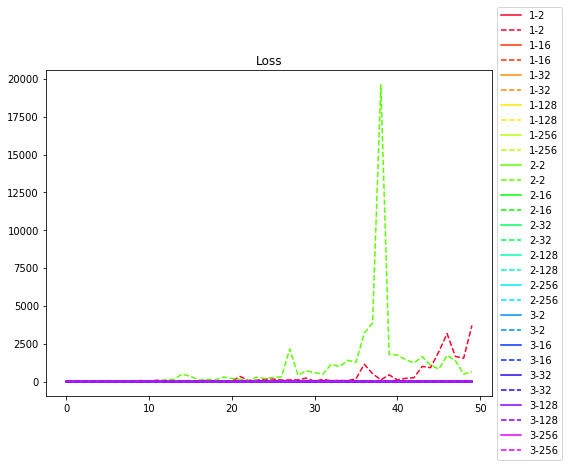

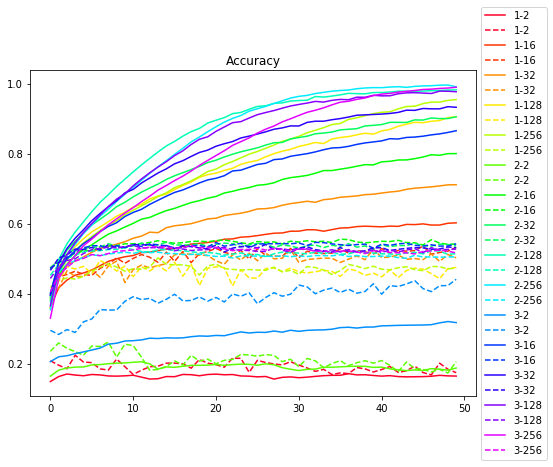

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline 
    
NUM_COLORS = len(results.keys())
cm = plt.get_cmap('gist_rainbow')
color_bar = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()